In [1]:
!ls  /home/suku/development/SummitDemo2019/data/data/dynatrace/ |wc -l

91


In [2]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.__version__


Using TensorFlow backend.


'1.15.0'

In [3]:
tf.test.is_gpu_available()

True

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [5]:
!ls -l /home/suku/development/SummitDemo2019/data/data/dynatrace/Summit2019-2008.jpg

-rw-r--r-- 1 suku suku 10703919 Nov 11 12:52 /home/suku/development/SummitDemo2019/data/data/dynatrace/Summit2019-2008.jpg


3.4.2
Total Number of Region Proposals: 1254


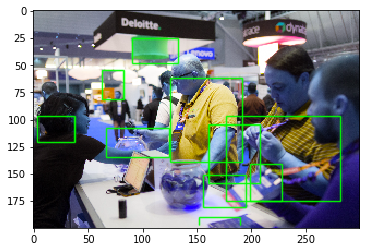

In [6]:
import sys
import cv2

path='/home/suku/development/SummitDemo2019/data/data/dynatrace/'
filename='Summit2019-2008.jpg'
print(cv2.__version__)
# speed-up using multithreads
cv2.setUseOptimized(True);
cv2.setNumThreads(4);
 
# read image
im = cv2.imread(os.path.join(path,filename))
# resize image
newHeight = 200
newWidth = int(im.shape[1]*200/im.shape[0])
im = cv2.resize(im, (newWidth, newHeight))    
 
# create Selective Search Segmentation Object using default parameters
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
 
# set input image on which we will run segmentation
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
#ss.switchToSelectiveSearchQuality()

# run selective search segmentation on input image
rects = ss.process()
print('Total Number of Region Proposals: {}'.format(len(rects)))
     
# number of region proposals to show
numShowRects = 10
# increment to increase/decrease total number
# of reason proposals to be shown
increment = 50
 
# create a copy of original image
imOut = im.copy()
 
# itereate over all the region proposals
for i, rect in enumerate(rects):
    # draw rectangle for region proposal till numShowRects
    if (i < numShowRects):
        x, y, w, h = rect
        cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    else:
        break

        
#show output
plt.imshow(imOut)
#cv2.imshow("Output", imOut)


In [7]:
#training

In [8]:
train_images=[]
train_labels=[]

In [9]:
def iou(bboxes1, bboxes2):
    x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)        
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))        
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)        
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)        
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)        
    return iou

In [10]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16


In [11]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()









_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__

In [12]:
print(len(vggmodel.layers))
for layers in (vggmodel.layers):
    print(layers)

print("========")    
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

23


In [13]:
bottleneck=vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(bottleneck)
model_final = Model(input = vggmodel.input, output = predictions)

/home/suku/miniconda3/envs/rcnnpy36/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [15]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [16]:
#delete from GPU memory
from keras import backend as K 
import gc
K.clear_session()
del vggmodel
gc.collect()
from numba import cuda
cuda.select_device(0)
cuda.close()